# Проект e-commerce: вариант 1 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from datetime import timedelta
import warnings
import requests
from urllib.parse import urlencode

# warnings.simplefilter(action='ignore', category='SettingWithCopyWarning')

urls = [
    'https://disk.yandex.ru/d/QXrVDUoQvFhIcg',  # ocd
    'https://disk.yandex.ru/d/0zWmh1bYP6REbw',  # ood
    'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'   # ooid
    ]
seps = [',', ',', ',']

def initial_read(url_lst=urls, sep_lst=seps):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df_list = []
    for i in range(3):
        url = base_url + urlencode(dict(public_key=url_lst[i]))
        response = requests.get(url)
        download_url = response.json()['href']
        df = pd.read_csv(filepath_or_buffer=download_url, sep=sep_lst[i])
        df_list.append(df)
    global ocd, ood, ooid
    ocd = df_list[0]  #  таблица с уникальными идентификаторами пользователей
    ood = df_list[1]  #  таблица заказов 
    ooid = df_list[2]  #  товарные позиции, входящие в заказы

initial_read()

#  приведем типы к datetime. Формат даты YYYY-MM-DD стандартынй для всех таблиц.
ood[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
     'order_delivered_customer_date', 'order_estimated_delivery_date']] \
= ood[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
       'order_delivered_customer_date', 'order_estimated_delivery_date']].astype('datetime64')
ooid['shipping_limit_date'] = ooid['shipping_limit_date'].astype('datetime64')


## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Посмотрим на распределение строк в таблице заказов, а именно, столбцы order_status, order_approved_at. Мы видим, что количество отмененных заказов 625, а разница между количеством платежей и количеством созданных заказов меньше.

Можно ли считать клиента совершившего платеж, который потом был возвращен, состоявшимся покупателем? Вопрос спорный. Если, например, товар был возвращен из-за брака, и т.о. попал в графу отмененных - то скорее да, чем нет. А если оплата прошла, клиент передумал, отменил заказ, вернул деньги - то точно нет.

Так как у нас нет подобной информации, будем считать что отмененные заказы не являются покупками.
Оперировать только статусом платежа некорректно. Разумнее провести фильтрацию по статусу заказа.

Наконец, убедимся, что order_id не дублируется - если статус заказа поменялся, строка переписывается, а не добавляется.

In [2]:
display(ood.count())
display(ood[['order_id','order_status']].groupby('order_status',  as_index=False)
        .count().rename(columns={'order_id': 'count'}))
ood['order_id'].nunique()

order_id                         99441
customer_id                      99441
order_status                     99441
order_purchase_timestamp         99441
order_approved_at                99281
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
order_estimated_delivery_date    99441
dtype: int64

,order_status,count
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


99441

Очевидный статус к учету - "delivered". Очевидное исключение - "canceled". 

Пройдемся по остальным статусам, и посмотрим что у нас с оплатой.
"created" не содержит платежей, поэтому в список покупателей эти строки не попадут.

Группы данных остальных статусов содержат ровно такое же количество строк с платежами, сколько всего в них строк.
Будем исходить из позитивной логики - клиент заплатил деньги и ждет заказ, который находится в некой промежуточной стадии и пока не отменен, а значит клиент является покупателем.


In [3]:
table1 = ood[['order_id', 'customer_id', 'order_status', 'order_approved_at', 'order_purchase_timestamp']] \
    .merge(ocd[['customer_id', 'customer_unique_id']], on='customer_id')
#  Рабочая временная таблица с нужными колонками

#  Посмотрим, сколько у нас строк с платежами
print('Количество строк, с ненулевым полем даты подтверждения платежа:')
print('created:',end='')
print(table1[(table1['order_status']=='created')&(~table1['order_approved_at'].isnull())].order_id.nunique())
print('approved:',end='')
print(table1[(table1['order_status']=='approved')&(~table1['order_approved_at'].isnull())].order_id.nunique())
print('unavailable:',end='')
print(table1[(table1['order_status']=='unavailable')&(~table1['order_approved_at'].isnull())].order_id.nunique())
print('shipped:',end='')
print(table1[(table1['order_status']=='shipped')&(~table1['order_approved_at'].isnull())].order_id.nunique())
print('invoiced:',end='')
print(table1[(table1['order_status']=='invoiced')&(~table1['order_approved_at'].isnull())].order_id.nunique())
print('processing:',end='')
print(table1[(table1['order_status']=='processing')&(~table1['order_approved_at'].isnull())].order_id.nunique())

Количество строк, с ненулевым полем даты подтверждения платежа:
created:0
approved:2
unavailable:609
shipped:1107
invoiced:314
processing:301


С нужными статусами определились, считаем интересующую нас метрику:

In [4]:
table1_b = table1[~table1['order_status'].isin(['canceled', 'created'])] #  эта таблица отображает совершенные покупки в рамках интересных нам столбцов
temp=table1_b.groupby('customer_unique_id', as_index=False).count().sort_values('order_id') # посчитаем число заказов по уникальным идентификаторам клиентов
temp[temp['order_id']==1].order_id.count() # посчитаем количество строк, с количеством покупок = 1


92633

Отсюда делаем вывод, что **количество покупателей с 1 покупкой составляет 92633**.

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

На первый взгляд, причины не доставки товара может быть 2: 
* Первая - заказ был отменен.
* Вторая - заказ опоздал. Даже если заказ приходит в текущем месяце, но позже обещанной даты, считаем, что обязательства магазина не выполнены и доставка сорвана.
    
    Соответственно заказ может опоздать по двум причинам:
    * Продавец не передал вовремя в логистическую службу товар (опоздал хотябы с одной позицией, если их несколько). В таком случае, виноват продавец.
    * Логистическая компания получила заказ от продавца в срок, но опоздала с доставкой. В таком случае, причиной сорваной доставки является невыполнение логистической компании своих обязательств.
    
Итого мы можем выделить 3 причины - отмена заказа, задежрка со стороны продавца, задержка со стороны логистической компании.

Для начала переведем даты в нужные форматы и объеденим столбцы из интересующих нас таблиц.

In [5]:
#скомпонуем нужные столбцы из двух таблиц
table2 = ood[['order_id', 'order_status',  'order_purchase_timestamp', \
              'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] \
.merge(ooid[['order_id','shipping_limit_date']], how = 'left', on = 'order_id')
table2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   order_status                   113425 non-null  object        
 2   order_purchase_timestamp       113425 non-null  datetime64[ns]
 3   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 4   order_delivered_customer_date  110196 non-null  datetime64[ns]
 5   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 6   shipping_limit_date            112650 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(2)
memory usage: 6.9+ MB


Для повышения точности расчета метрик уточним одно важное обстоятельство. Между созданием и получением заказа существует временной лаг. Таблицы актуальны для момента выгрузки. Этот момент с хорошей точностью можно считать верменем создания последнего заказа. Обещанные даты доставки выходят за пределы этой даты примерно на месяц вперед, мы не знаем опоздает ли заказ. Поэтому временной период с последней даты создания заказа по последнюю дату обещанного срока доставки в интервал не входит. **Интересующий нас интервал - с первой обещанной даты доставки по последнюю дату создания заказа.**

В данных присутствуют пропуски в графе даты доставки. Такие случаи мы будем считать сорванной доставкой, т.к. на момент выгрузки данных обещанная дата уже прошла (с учетом нашей фильтрации - мы не берем те строки, где обещанная дата позже времени выгрузки таблицы), но строки со статусом unavailable учитываться не будут - статус недоступен, об этих заказах нам не известно, доставлены ли они и когда. О том что сатус unavailable говорит о недоступности именно статуса, а не заказа, косвенно говорит то, что в order_status нет ни одной нулевой строки.

Извлечем cреднемесячные данные по каждой причине:

In [6]:
#  месяцев в отчетном периоде
maxd = ood['order_purchase_timestamp'].max()
mind = ood['order_estimated_delivery_date'].min()
period_mnth = 12 * (maxd.year - mind.year) + (maxd.month - mind.month) #=25. Если бы мы считали по крайним датам estimated - месяцев было бы 26.

table2 = table2[table2['order_estimated_delivery_date']<maxd] # фильтрация по временному интервалу

cncl = table2[table2['order_status']=='canceled'].order_id.nunique() #=621, количество отмененных заказов за период с учетом фильтрации
print('Среднее отмененных в месяц:', end='')
print(round(cncl/period_mnth,2))

#Считаем опоздунов, не забыв исключить отмененные заказы.

tot_delays_table = table2[~table2['order_status'].isin(['canceled','unavailable']) \
                 &((table2['order_estimated_delivery_date']-table2['order_delivered_customer_date']<pd.Timedelta(value=0))\
                          |(table2['order_delivered_customer_date'].isnull()))]

#Что мы сделали в блоке выше - убрали отмененные заказы и заказы статус которых недоступен. 
#Взяли строки, где доставка либо опоздала, либо еще не осуществилась.
tot_delays = tot_delays_table.order_id.nunique()
#Всего опозданий

print('Среднемесячное число опозданий(всех):', end='')
print(round(tot_delays/period_mnth,2))

seller_delays_table = tot_delays_table[tot_delays_table['shipping_limit_date'] - tot_delays_table['order_delivered_carrier_date']<pd.Timedelta(value=0)]
seller_delays = seller_delays_table.order_id.nunique()
# Опозданий по вине продовца. NB! Так как нам достаточно опоздания хотя бы по одной позиции из заказа, 
# нам не нужно переживать из-за того, что несколько строк может соответствовать данному order_id, 
# данный order_id все равно попадет в список опозданий.
print('Среднемесячное число опозданий по вине продавца:', end='')
print(round(seller_delays/period_mnth,2))

# Записи в которых все позиции переданы в доставку вовермя, но опоздали к клиенту, запишем как вину логистической службы
delivery_delays_table = tot_delays_table[~tot_delays_table['order_id'].isin(seller_delays_table['order_id'])]
delivery_delays = delivery_delays_table.order_id.nunique()
print('Среднемесячное число опозданий по вине логистической службы:', end='')
print(round(delivery_delays/period_mnth,2))
# Сумма двух средних свпадает со сердним общего, хороший знак того, что мы не ошиблись. 

Среднее отмененных в месяц:24.84
Среднемесячное число опозданий(всех):382.52
Среднемесячное число опозданий по вине продавца:90.24
Среднемесячное число опозданий по вине логистической службы:292.28


Сведем результат к таблице.

В среднем сорванных доставок в месяц по причинам:

| Отменено | Опоздало ||
| :- | -: |-: |
|  | 382.52 ||
|24.84|По вине продавца|По вине логистической службы|
|  | 90.24 | 292.28 |

Всего закзов 3461 в месяц в среднем, около 12% сорванных доставок, что выглядит разумным.

PS. Вообще, estimated это скорее оценочная, а не обещанная дата доставки. То есть "привезем примерно к ...", поэтому возможно мы тут поступили излишне строго, посчитав ее за "дедлайн". С другой стороны дедлайна для доставки нет, поэтому мы просто взяли оценочное время за дедлайн.

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Здесь в качестве опорной даты лучше всего брать дату создания заказа - хоть факт покупки и подтверждается проведением платежа, здесь нам скорее интересно настроение/потребность покупателя.

In [7]:
table3 = ood[['order_id', 'order_status', 'order_purchase_timestamp']] \
.merge(ooid[['order_id', 'product_id']], how = 'left', on = 'order_id')
table3 = table3[~table3['order_status'].isin(['canceled', 'created'])] #  Уберем отмененные заказы и заказы со статусом created
table3['day_of_week'] = table3['order_purchase_timestamp'].dt.weekday #  Выделим день недели
temp3 = table3.groupby(['product_id', 'day_of_week'], as_index=False).order_id.nunique() # сгруппируем по продукту и дню недели
ttemp3 = temp3.sort_values('order_id').groupby('product_id').tail(1) #  сгруппируем отсортированное количество покупок (оно в order_id)
#  Возьмем строку с самым большим числом заказов в группе

top_day_of_week=ttemp3[['product_id', 'day_of_week']]
display(top_day_of_week) # Самый популярный день для каждого товара.0 - пн, 6 -вск.
print(temp3.product_id.nunique()) # Убедимся, что число уикальных product_id равно числу строк в искомой таблице.

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,6
37749,9f81413382c6e7b2b2eaff6930f1fd98,4
37750,9f82fdef2a36bb15d22d70af1aedb3ce,6
37751,9f8429b91bcd34baae1d1fd12505abfb,3
37758,9f8aa40ada6e2b65a3bb5643754bf262,4
...,...,...
15814,422879e10f46682990de24d770e7f83d,3
49935,d1c427060a0f73f6b889a5c7c61f2ac4,0
20011,53b36df67ebb7c41585e8d54d6772e08,1
40828,aca2eb7d00ea1a7b8ebd4e68314663af,3


32735


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

В промежуток не входит ни одного вискосного года, поэтому словарь месяц - кол-во недель корректен для всего промежутка 

In [8]:
table4 = ood[['order_id', 'customer_id', 'order_status', 'order_approved_at', 'order_purchase_timestamp']] \
.merge(ocd[['customer_id', 'customer_unique_id']], on = 'customer_id')#  С тем, что такое "Покупатель" мы определились на первом шаге нашего исследования.
table4 = table4[~table4['order_status'].isin(['canceled', 'created'])]

weeks_dtbs={1: 31/7, 2: 28/7, 3: 31/7, 4: 30/7, 5: 31/7, 6:30/7, 7: 31/7, 8: 31/7, 9: 30/7, \
            10: 31/7, 10: 31/7, 11: 30/7, 12: 31/7}

table4['month'] = table4['order_purchase_timestamp'].dt.year.astype(str) + ', ' \
+ table4['order_purchase_timestamp'].dt.month.astype(str) #  месяц
table4['nmb_of_weeks'] = table4['order_purchase_timestamp'].dt.month.map(weeks_dtbs) #сколько недель в месяце

start_point = table4.order_purchase_timestamp.min() #  начальная временная точка
end_point = table4.order_purchase_timestamp.max() #  конечная временная точка

temp4 = table4.groupby(['customer_unique_id', 'month'], as_index=False).order_id.count()

temp4['mnth_size'] = temp4['month'].str.split().str[1].astype(int).map(weeks_dtbs)
temp4['avg_week_count'] = temp4['order_id']/temp4['mnth_size'] #  чтобы посчитать кол-возаказов в неделю надо разделить числопокупок в месяце на кол-во недель.
result_table_step4 = temp4.drop(['order_id','mnth_size'], axis=1)
result_table_step4


,customer_unique_id,month,avg_week_count
0,0000366f3b9a7992bf8c76cfdf3221e2,"2018, 5",0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,"2018, 5",0.225806
2,0000f46a3911fa3c0805444483337064,"2017, 3",0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,"2017, 10",0.225806
4,0004aac84e0df4da2b147fca70cf8255,"2017, 11",0.233333
...,...,...,...
97450,fffcf5a5ff07b0908bd4e2dbc735a684,"2017, 6",0.233333
97451,fffea47cd6d3cc0a88bd621562a9d061,"2017, 12",0.225806
97452,ffff371b4d645b6ecea244b27531430a,"2017, 2",0.250000
97453,ffff5962728ec6157033ef9805bacc48,"2018, 5",0.225806


Результат представлен в датафрейме result_table_step4, колонка customer_unique_id - уникальный идентификатор пользователя, month - Год и месяц, avg_week_count - сколько данный пользователь совершал в данном месяце покупок в среднем в неделю.
Если покупатель не совершал покупок вэтом месяце - строка отсутствует

## 5. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц

Полный год можно выделить только один 2017-01-01 - 2018-01-01. По нему и проведем когортный анализ. Выборка из 12 месяцев позволит увидеть тенденции внутри года. Привлечение данных за 2018 год не сильно увеличит реперзентатитвность, как минимум потому, что год не полный, при этом снизится читаемость таблицы. Более того, в 2016 году было мало покупок - это судя по всему начало работы магазина, и эти данные мало репрезентативны. При этом мы исключим из когорт пользователей, которые совершали покупки в 2016 году.

In [9]:
table5 = table1_b[(table1_b['order_purchase_timestamp']>pd.to_datetime('2017-01-01'))&(table1_b['order_purchase_timestamp']<pd.to_datetime('2018-01-01'))]

# Уберем клиентов за 2016 год. За 2016 год было всего 303 записи, поэтому из датафрейма за 2017 отфильтровалось 5 клиентов.
prvs_lst = table1_b[table1_b['order_purchase_timestamp']<pd.to_datetime('2017-01-01')].customer_unique_id
table5 =table5[~table5['customer_unique_id'].isin(prvs_lst)]
table5['mnth'] = table5['order_purchase_timestamp'].dt.month

month_lst = [] #Список месяцев для исключения при подсчете новых клиентов для каждой когорты
new_customers = [] #Список числа новых клиентов (знаменатель для каждой кагорты)
for i in range(12): # чтобы праавильно учитывать новых клиентов, необходимо исключатьклиентов из предыдущих когорт
    accounted = table5[table5['mnth'].isin(month_lst)].customer_unique_id # Датафрейм с предыдущими месяцами.
    nun = table5[(table5['mnth']==i+1)&(~table5['customer_unique_id'].isin(accounted))].customer_unique_id.nunique()
    month_lst.append(i+1)
    new_customers.append(nun)
    print(nun) # Число новых клиентов


762
1735
2603
2334
3571
3126
3868
4162
4112
4446
7268
5477


Мы определились с количеством новых клиентов в каждой когорте.\
Количество новых клиентов не сильно отличается от количества уникальных id клиентов в каждом месяце (не показано).\
Это не удивительно, если вспомнить, сколько у нас клиентов совершивших одну покупку.\
Соответственно и retention можно ожидать очень низкий.\
Рассчитаем его:

In [10]:
month_lst = []
dct = {}
for i in range(12):
#     Как и в предыдущем цикле сформируем списики новых клиентов в кагорте
    accounted = table5[table5['mnth'].isin(month_lst)].customer_unique_id 
    newcst_s = table5[(table5['mnth']==i+1)&(~table5['customer_unique_id'].isin(accounted))].customer_unique_id #датафрейм с новыми клиентами этой когороты
    lst = []
    for j in range(i,12):
        ret = round(table5[(table5['mnth']==j+1)&(table5.customer_unique_id.isin(newcst_s))].customer_unique_id.nunique()/new_customers[i], 4)
        lst.append(ret)
    dct['2017-'+str(i+1)] = lst
    month_lst.append(i+1)
df = pd.DataFrame.from_dict(dct, orient='index')
df = df.rename_axis(index='Cohort', columns="Cohort period")


ret_style = (df
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='PuBu',axis=None, vmax = 0.007)  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ret_style

Cohort period,0,1,2,3,4,5,6,7,8,9,10,11
Cohort,,,,,,,,,,,,
2017-1,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.00%,0.39%,0.13%
2017-2,100.00%,0.23%,0.29%,0.12%,0.40%,0.12%,0.23%,0.17%,0.17%,0.23%,0.12%,
2017-3,100.00%,0.50%,0.35%,0.38%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,,
2017-4,100.00%,0.60%,0.21%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,,,
2017-5,100.00%,0.48%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,,,,
2017-6,100.00%,0.45%,0.35%,0.42%,0.26%,0.38%,0.35%,,,,,
2017-7,100.00%,0.52%,0.34%,0.26%,0.28%,0.21%,,,,,,
2017-8,100.00%,0.67%,0.34%,0.26%,0.36%,,,,,,,
2017-9,100.00%,0.68%,0.54%,0.29%,,,,,,,,


Как мы и ожидали, retention в целом небольшой - меньше процента. Причины могут быть разные - например если это товары народного потребления, то магазин еще не раскрутился. Или, если товар специфический и покупается редко, например, в случае если это промышленное оборудование, тогда уже наш подход неверен, и когорты надо делать по годам.

Немного дополним таблицу, чтобы иметь данные по 3 последним месяцам - возьмем еще 3 месяца из 2018 года:

In [26]:
table5_2 = table1_b.copy()
table5_2 = table5_2[table1_b['order_purchase_timestamp']>pd.to_datetime('2018-01-01')]
table5_2['mnth'] = table5_2['order_purchase_timestamp'].dt.month
month_lst = []
dct = {}
for i in range(12):
#     Как и в предыдущем цикле сформируем списики новых клиентов в кагорте
    accounted = table5[table5['mnth'].isin(month_lst)].customer_unique_id 
    newcst_s = table5[(table5['mnth']==i+1)&(~table5['customer_unique_id'].isin(accounted))].customer_unique_id
    lst = []
    for j in range(i,12):
        ret = round(table5[(table5['mnth']==j+1)&(table5.customer_unique_id.isin(newcst_s))].customer_unique_id.nunique()/new_customers[i], 4)
        lst.append(ret)
    for k in range(3):
        ret = round(table5_2[(table5_2['mnth']==k+1)&(table5_2.customer_unique_id.isin(newcst_s))].customer_unique_id.nunique()/new_customers[i], 4)
        lst.append(ret)
    dct['2017-'+str(i+1)] = lst
    month_lst.append(i+1)
df = pd.DataFrame.from_dict(dct, orient='index')
df = df.rename_axis(index='Cohort', columns="Cohort period")


ret_style = (df
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='PuBu',axis=None, vmax = 0.007)  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ret_style

Cohort period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Cohort,,,,,,,,,,,,,,,
2017-1,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.00%,0.39%,0.13%,0.79%,0.39%,0.13%
2017-2,100.00%,0.23%,0.29%,0.12%,0.40%,0.12%,0.23%,0.17%,0.17%,0.23%,0.12%,0.29%,0.17%,0.17%,
2017-3,100.00%,0.50%,0.35%,0.38%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,0.38%,0.15%,0.23%,,
2017-4,100.00%,0.60%,0.21%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,,,
2017-5,100.00%,0.48%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,0.25%,0.28%,0.25%,,,,
2017-6,100.00%,0.45%,0.35%,0.42%,0.26%,0.38%,0.35%,0.22%,0.13%,0.22%,,,,,
2017-7,100.00%,0.52%,0.34%,0.26%,0.28%,0.21%,0.31%,0.10%,0.18%,,,,,,
2017-8,100.00%,0.67%,0.34%,0.26%,0.36%,0.53%,0.29%,0.26%,,,,,,,
2017-9,100.00%,0.68%,0.54%,0.29%,0.46%,0.22%,0.22%,,,,,,,,


В итоге, **наибольший retention на 3 месяц - для июньской когорты и состовляет он 0,42%.**

## 6. RFM-сегментированный анализ

RFM-сегментный анализ, как подсказывает литература, слабо применим к магазинам "одной покупки". Поэтому не приходится ожидать информативный результат.

Изучаемый период - последние 365 дней на момент выгрузки данных.
Для пердставления данных в наиболее читаемом виде будем придерживаться следующей тактики - частоту покупок будем измерять как кол-во в год, монетарность в количестве потраченного за год.

In [12]:
# tot_years = round((ood.order_purchase_timestamp.max()-ood.order_purchase_timestamp.min()).days/365,3)
start_point = pd.to_datetime('2017-10-17')

tot_tbl = ocd.merge(ood, how = 'left', on = 'customer_id')
tot_tbl = tot_tbl.merge(ooid, how = 'left', on = 'order_id')
tot_tbl = tot_tbl.query("order_status not in ('canceled','created','unavailable')") # хоть unavalible попал в число покупок на сгинатурном уровне, мы его не берем, т.к. нет возможность расчитать метрики по этим позициям
tot_tbl = tot_tbl[tot_tbl['order_purchase_timestamp']>start_point] #Выберем нужные данные - на 1 годназад от точки выгрузки.

tot_tbl['rescency'] = (maxd - tot_tbl['order_purchase_timestamp']).dt.days # число дней с послдней покупки до момента выгрузки.
data = tot_tbl.groupby('customer_unique_id').agg({'order_id':'nunique','price':'sum','rescency':'min'}) #для каждого клиента частота - как кол-во заказов за год, монетарность как сумма всех покупок, недавность - промжеуток времени ссамой последней покупки
data['order_id'] = round(data['order_id'], 3)
data = data.rename(columns={'order_id':'frequency_per_year','price':'spent_per_year'}).reset_index()
data['spent_per_year'] = round(data['spent_per_year'], 2)
data



,customer_unique_id,frequency_per_year,spent_per_year,rescency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,163
2,0004aac84e0df4da2b147fca70cf8255,1,180.00,336
3,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,194
4,00050ab1314c0e55a6ca13cf7181fecf,1,27.99,180
...,...,...,...,...
67036,fffb09418989a0dbff854a28163e47c6,1,58.00,303
67037,fffbf87b7a1a6fa8b03f081c5f51a201,1,149.00,293
67038,fffcc512b7dfecaffd80f13614af1d16,1,688.00,189
67039,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,310


Разбиение по группам будем проводить по принципу квантилирования - все метрики будут разбиты на равномерные промежутки:

In [13]:
max_f = data.frequency_per_year.max()
min_f = 0
max_m = data.spent_per_year.max()
min_m = 0
max_r = data.rescency.max()
min_r = 0

In [14]:
data["R"] = 6-np.ceil(data.rescency.div(max_r).mul(5)).astype('int64') # логика присвоения очков - "чем больше, тем лучше", поэтому большему R соответствует меньшее количество дней
data["F"] = np.ceil(data.frequency_per_year.div(max_f).mul(5)).astype('int64')
data["M"] = np.ceil(data.spent_per_year.div(max_m).mul(5)).astype('int64')
data


,customer_unique_id,frequency_per_year,spent_per_year,rescency,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,160,3,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,163,3,1,1
2,0004aac84e0df4da2b147fca70cf8255,1,180.00,336,1,1,1
3,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,194,3,1,1
4,00050ab1314c0e55a6ca13cf7181fecf,1,27.99,180,3,1,1
...,...,...,...,...,...,...,...
67036,fffb09418989a0dbff854a28163e47c6,1,58.00,303,1,1,1
67037,fffbf87b7a1a6fa8b03f081c5f51a201,1,149.00,293,1,1,1
67038,fffcc512b7dfecaffd80f13614af1d16,1,688.00,189,3,1,1
67039,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,310,1,1,1


Квантилирование: 

*NB! Наибольшему rescency соответствует намиеньшие промежутки времени с даты последней покупки*

In [15]:
# Промежутки для каждой когорты:
mr,mf,mm = {},{},{}
for i in range(5):
    mr[5-i] = str(int((max_r-min_r)/5 * (i) + min_r)) + '-' + str(int((max_r-min_r)/5 * (i+1) + min_r))
    mf[i+1] = str(int((max_f-min_f)/5 * (i) + min_f)) + '-' + str(int((max_f-min_f)/5 * (i+1) + min_f))
    mm[i+1] = str(int((max_m-min_m)/5 * (i) + min_m)) + '-' + str(int((max_m-min_m)/5 * (i+1) + min_m))

print('rescency:', end='')
print(mr)
print('frequency:', end='')
print(mf)
print('monetary:', end='')
print(mm)

rescency:{5: '0-73', 4: '73-146', 3: '146-219', 2: '219-292', 1: '292-365'}
frequency:{1: '0-2', 2: '2-4', 3: '4-6', 4: '6-8', 5: '8-10'}
monetary:{1: '0-1432', 2: '1432-2864', 3: '2864-4296', 4: '4296-5728', 5: '5728-7160'}


Распределение покупателей по частотам покупки

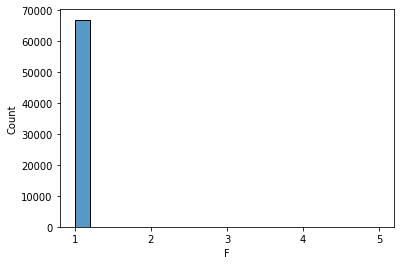

In [16]:
plt.xticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5])
sns.histplot(data=data,x='F',binwidth=0.2)
plt.show()

Распределение по недавности последней покупки:

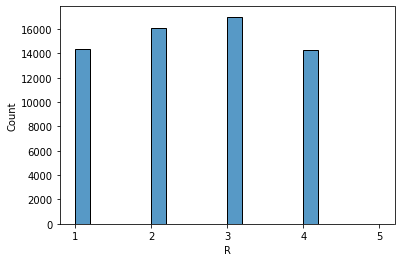

In [17]:
plt.xticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5])
sns.histplot(data=data,x='R',binwidth=0.2)
plt.show()

Распределение монетарности клиентов для разных сочетаний R и F:

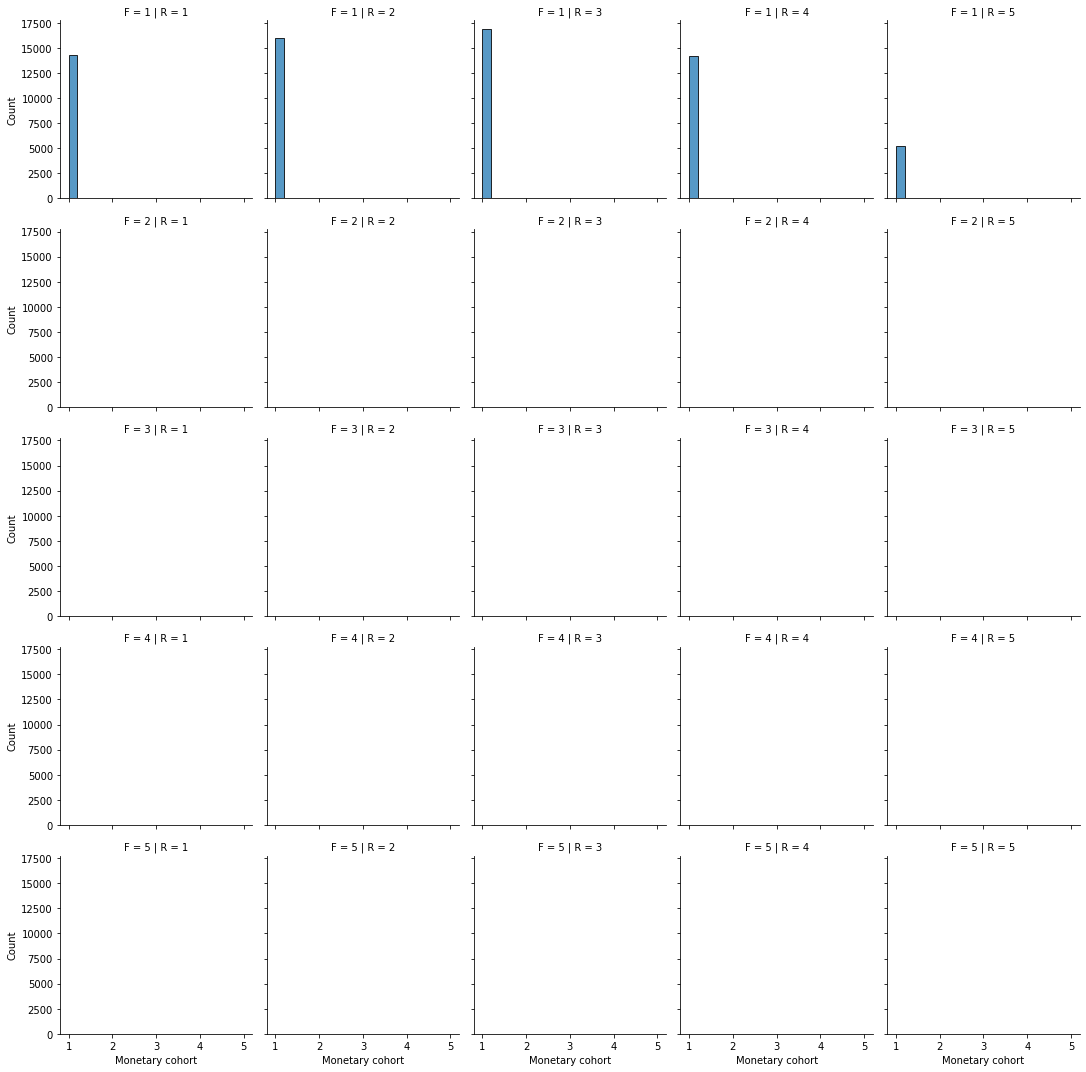

In [18]:
g = sns.FacetGrid(data, col="R", row = 'F')
g.map(sns.histplot,'M',binwidth=0.2)
g.set_axis_labels("Monetary cohort","Count")
unique_x_ticks = sorted(data['M'].unique())
g.set(xticks=unique_x_ticks, xticklabels=unique_x_ticks)
    
plt.show()

Как и ожидалось, результат мало информативен - слишком много клиентов с одной покупкой.
Чтобы рассмотреть данные получше, можно посмотреть на распределения в автомасштабе:

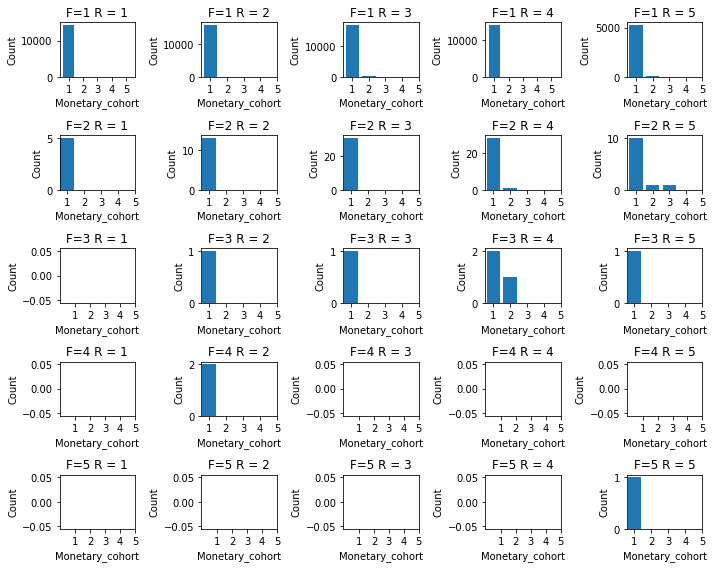

In [19]:
x = data.groupby(['F','R','M'],as_index=False).count()

fig, axes = plt.subplots(5, 5, figsize=(10, 8))

for i in range(5):
    for j in range(5):
        curent_data = x[(x['F']==i+1)&(x['R']==j+1)]
        xv = curent_data.M
        yv = curent_data.customer_unique_id

        axes[i,j].bar(xv, yv)
        axes[i,j].set_title(f"F={i+1} R = {j+1}")
        axes[i,j].set_xticks(unique_x_ticks)
        axes[i,j].set_xlabel('Monetary_cohort')
        axes[i,j].set_ylabel('Count')


plt.tight_layout()    
fig.show()

Либо на те же данные в логарифмическом масштабе:

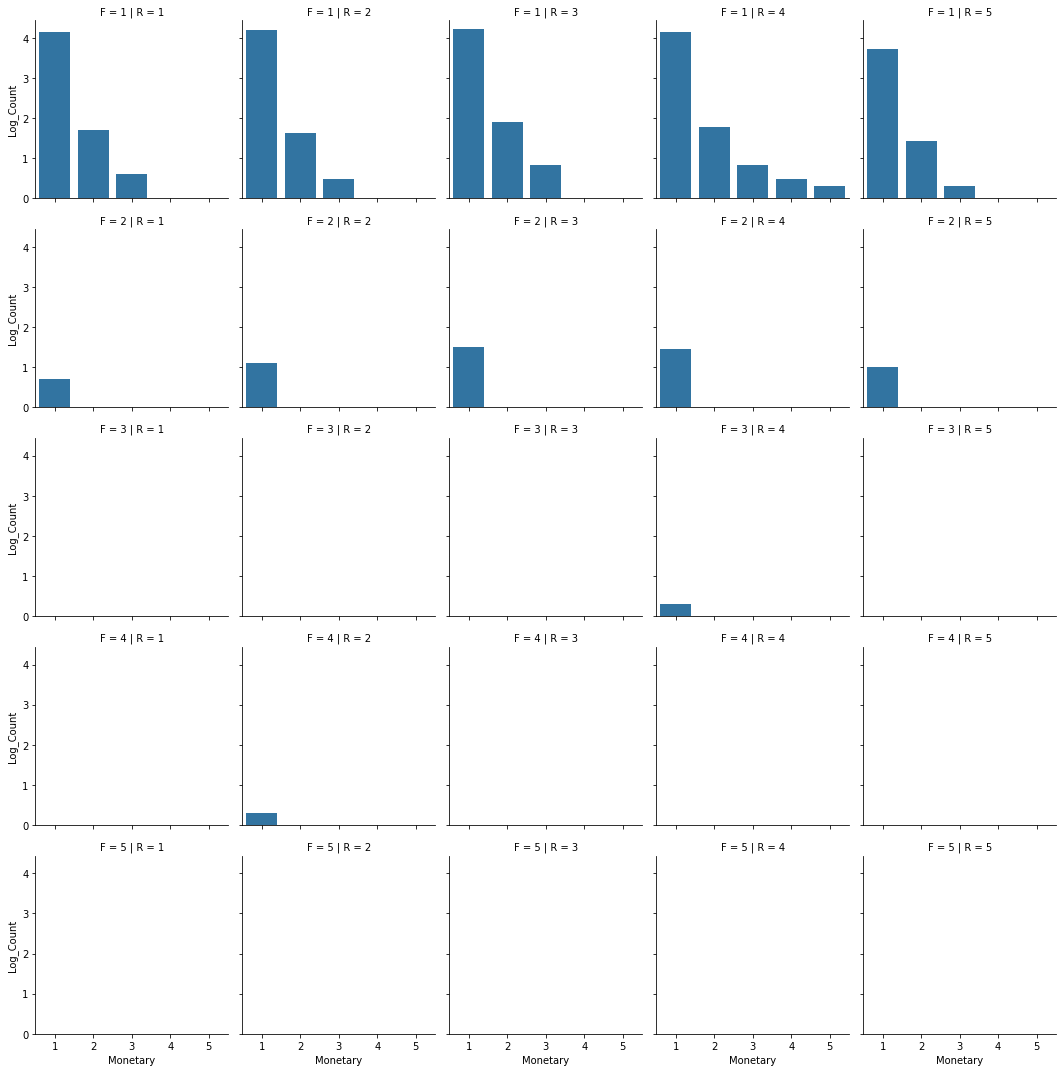

In [20]:
x['log_count'] = np.log10(x['customer_unique_id'])
x.dtypes
unique_x_ticks = [1,2,3,4,5]
g2 = sns.FacetGrid(data = x, col="R", row = 'F')
g2.map(sns.barplot, 'M','log_count',order=unique_x_ticks)
g2.set_axis_labels("Monetary","Log_Count")

g.set(xticks=unique_x_ticks, xticklabels=unique_x_ticks)
plt.show()

Учитывая специфику данных, нет смысла делить клиентов на большое количество сегментов. Выделим всего 4 сатуса клиентов - активные, новые, спящие, и с промежуточным статусом:

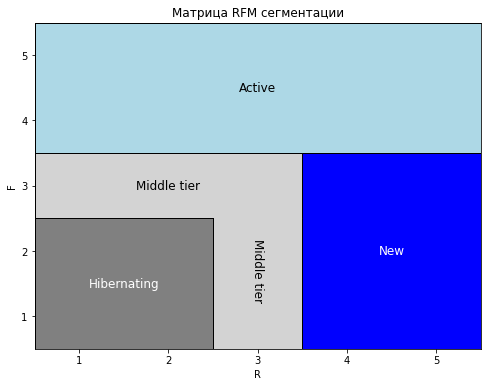

In [21]:
matrix = np.full((5, 5), '') 

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

ax.set_title('Матрица RFM сегментации')
ax.set_xlabel('R')
ax.set_ylabel('F')

       
rect = Rectangle((0, 3), 5, 2, facecolor='lightblue', edgecolor='black')
ax.add_patch(rect)
ax.text(2.5, 4, 'Active', ha='center', va='center', fontsize=12)

rect = Rectangle((3, 0), 2, 3, facecolor='blue', edgecolor='black')
ax.add_patch(rect)
ax.text(4, 1.5, 'New', ha='center', va='center', fontsize=12, color = 'white')

rect = Rectangle((0, 0), 2, 2, facecolor='gray', edgecolor='black')
ax.add_patch(rect)
ax.text(1, 1, 'Hibernating', ha='center', va='center', fontsize=12, color = 'white')

rect = Rectangle((0, 2), 3, 1, facecolor='lightgrey', edgecolor='black')
ax.add_patch(rect)
ax.text(1.5, 2.5, 'Middle tier', ha='center', va='center', fontsize=12)

rect = Rectangle((2.01, 0), 0.99, 2.1, facecolor='lightgrey', edgecolor=None)
ax.add_patch(rect)
ax.text(2.5, 1.2, 'Middle tier', ha='center', va='center', fontsize=12, rotation=270)

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5], rotation=0)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5], rotation=0)

plt.show()

In [22]:
segt_map = {
    r'[1-5][4-5]': 'active',
    r'[4-5][1-3]': 'new',
    r'[1-2][1-2]': 'hibernation',
    r'[1-3]3': 'middle tier',
    r'3[1-3]': 'middle tier'
    }

Посмотрим на распределение по сатусам. Не смотря на то, что активным клиентам выделено аж 10 ячеек в матрице их все равно меньшинство.

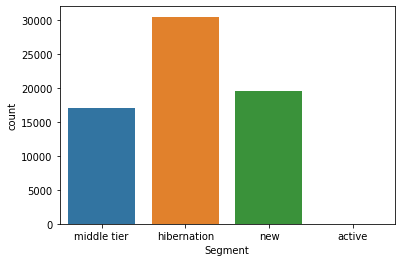

In [23]:
data['RFM_score'] = data['R'].astype('str') + data['F'].astype('str') + data['M'].astype('str')
data['Segment'] = data['RFM_score'].str[0:2]
data['Segment'] = data['Segment'].replace(segt_map, regex=True)
sns.countplot(x = data.Segment)

plt.show()

##  Итог. Обсуждение результатов.

За расчетный период у нас 92633 покупателей совершили только одну покупку - более 90% от всех клиентов. Сорванных доставок около 12%.

Когортный анализ и RFM анализ не применим к таким данным. Попробуем разобраться, почему.
Псомторим на график продаж по неделям:

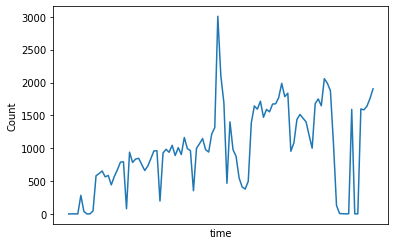

In [27]:
ood2=ood
ood2['week'] = ood2['order_purchase_timestamp'].dt.isocalendar().week.astype('str')
ood2['year'] = ood2['order_purchase_timestamp'].dt.year.astype('str')
ood2['time'] = ood2['year'] + ' ' + ood2['week']
tend = ood2.groupby('time', as_index=False).agg({'order_purchase_timestamp':'count'})
sns.lineplot(data=tend, x='time', y='order_purchase_timestamp')
plt.ylabel('Count')
plt.xticks([])


plt.show()

Помимо периодичных падений и несколько выделяющихся пиков, наблюдается устойчивая тенденция роста, которая еще не вышла на насыщение. Таким образом, помимо возможной специфики товаров, можно также с увереннностью утверждать, что магазин еще "не вышел на режим".